<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the dataset

In [0]:
import pickle
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')
 

In [4]:
import numpy as np
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))


loaded 160000 signal vectors into X(160000, 2, 128) and their corresponding labels into labels(160000, 2)


In [5]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
snrList = [str(2*i-20) for i in range(20)]  # snrList = -20, -18, -16 , ... ,0, ... ,18
snr = snrList[19]
numberOfEachExamples = 1000
print("SNR :", snr)

SNR : 18


In [0]:
output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)

In [8]:
Xsnr = np.zeros(shape=(X.shape[0],X.shape[1],X.shape[2]+1))
for i in range(X.shape[0]):
    snr = int(labels[i,1])
    Xsnr[i,0,:] = np.insert(X[i,0,:],0,snr)
    Xsnr[i,1,:] = np.insert(X[i,1,:],0,snr)
    
print(Xsnr.shape)

(160000, 2, 129)


In [9]:
###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xsnr, y, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
#X_train, X_test, y_train, y_test = train_test_split(Xsnr, y, test_size = 1, random_state = 0)

print(X_train.shape)
print(X_test.shape)

(128000, 2, 129)
(32000, 2, 129)


In [10]:
X_train = X_train[:,:,1:] # snr important for train

y_test18 = []
X_test18 = []

for i in range(X_test.shape[0]):
    if X_test[i,0,0] == 18:
        X_test18.append(X_test[i])
        y_test18.append(y_test[i])
        
X_test18 = np.array(X_test18)
y_test18 = np.array(y_test18)        
X_test18 = X_test18[:,:,1:]


print(X_train.shape)
print(X_test18.shape)

(128000, 2, 128)
(1653, 2, 128)


In [11]:
# Change IQ to amplitude and phase
X_cmplx = X_train[:,0,:] + 1j* X_train[:,1,:]    
X_amp = np.abs(X_cmplx)
X_ang = np.arctan2(X_train[:,1,:],X_train[:,0,:]) / np.pi
    
X_amp = np.reshape(X_amp,(-1,1,128))
X_ang = np.reshape(X_ang,(-1,1,128))
    
X_train_AmpPhs = np.concatenate((X_amp,X_ang), axis=1) 
##
X_cmplx = X_test18[:,0,:] + 1j* X_test18[:,1,:]    
X_amp = np.abs(X_cmplx)
X_ang = np.arctan2(X_test18[:,1,:],X_test18[:,0,:]) / np.pi
    
X_amp = np.reshape(X_amp,(-1,1,128))
X_ang = np.reshape(X_ang,(-1,1,128))
    
X_test18_AmpPhs = np.concatenate((X_amp,X_ang), axis=1) 
##

print(X_train_AmpPhs.shape)
print(X_test18_AmpPhs.shape)

(128000, 2, 128)
(1653, 2, 128)


In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = X_train.reshape([X_train.shape[0],256])
#X_train = X_train_AmpPhs.reshape([X_train.shape[0],256])
X_train = sc.fit_transform(X_train)
X_train = X_train.reshape([X_train.shape[0],2,128])
#X_test = X_test.reshape([1600,256])
X_test18 = X_test18.reshape([X_test18.shape[0],256])
#X_test18 = X_test18_AmpPhs.reshape([X_test18.shape[0],256])
X_test18 = sc.transform(X_test18)
X_test18 = X_test18.reshape([X_test18.shape[0],2,128])

# Reshape
X_train = X_train.reshape(-1,2, 128, 1)   #Reshape for CNN -  (6400,2,128)->(6400,2,128,1)!!
X_test18 = X_test18.reshape(-1,2, 128, 1)

print(X_train.shape)
print(X_test18.shape)

(128000, 2, 128, 1)
(1653, 2, 128, 1)


# Making CNN0 model 
(Article : Convolutional Radio Modulation Recognition Networks - Timothy J. O’Shea)


In [13]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.5
classifier.add(Conv2D(filters=192, kernel_size=(1,3), input_shape =  (2,128,1), padding='same', activation = 'relu')) 
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(filters=128,kernel_size=(2,3),  padding='same', activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(filters=128,kernel_size=(1,3),  padding='same', activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(filters=64,kernel_size=(1,3),  padding='same', activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(filters=64,kernel_size=(1,3),  padding='same', activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(filters=64,kernel_size=(1,3),  padding='same', activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(filters=32,kernel_size=(1,3),  padding='same', activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(filters=32,kernel_size=(1,3),  padding='same', activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(filters=32,kernel_size=(1,3),  padding='same', activation = 'relu'))
classifier.add(Dropout(rate = dout))




classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")

Using TensorFlow backend.
W0906 19:12:57.500992 140341735409536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 19:12:57.518722 140341735409536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 19:12:57.524298 140341735409536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 19:12:57.542138 140341735409536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 128, 192)       768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 128, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 128, 128)       147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 128, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 128, 128)       49280     
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 128, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 128, 64)       

#Making CNN1 model (one-convolutional-layer)
(Thesis :DEEP NEURAL NETWORK ARCHITECTURES FOR MODULATION CLASSIFICATION)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.5

classifier.add(Conv2D(256,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")

# Making CNN2 model  (two-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(256,(1,3), input_shape =  (2,128,1), activation = 'relu', padding='same')) # 256=number of filter
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,(2,3), activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")


#Making CNN3 model (two-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4

classifier.add(Conv2D(80,2,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Conv2D(256,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")

#Making CNN4 model (four-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(256,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,2,3, activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))

classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")


#Making CNN5 model (five-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(384,1,3, input_shape =  (2,128,1), activation = 'relu')) 
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,2,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")

# Fitting model

In [32]:
batch = 1024
epoch = 100

history = classifier.fit(X_train, y_train, batch_size = batch, epochs = 100, validation_data=(X_test18, y_test18))
#history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch)

Train on 128000 samples, validate on 1653 samples
Epoch 1/100
128000/128000 [==============================] - 67s 524us/step - loss: 1.9476 - acc: 0.1869 - val_loss: 1.8754 - val_acc: 0.3775
Epoch 2/100
128000/128000 [==============================] - 64s 504us/step - loss: 1.7538 - acc: 0.2769 - val_loss: 1.6858 - val_acc: 0.3932
Epoch 3/100
128000/128000 [==============================] - 65s 504us/step - loss: 1.6617 - acc: 0.3260 - val_loss: 1.6736 - val_acc: 0.3303
Epoch 4/100
128000/128000 [==============================] - 64s 502us/step - loss: 1.5535 - acc: 0.3669 - val_loss: 1.1767 - val_acc: 0.4785
Epoch 5/100
128000/128000 [==============================] - 64s 502us/step - loss: 1.4653 - acc: 0.4002 - val_loss: 1.2466 - val_acc: 0.4755
Epoch 6/100
128000/128000 [==============================] - 64s 502us/step - loss: 1.4090 - acc: 0.4164 - val_loss: 1.2496 - val_acc: 0.4912
Epoch 7/100
128000/128000 [==============================] - 64s 501us/step - loss: 1.3790 - acc: 

# Save model

In [33]:
dic = "/content/drive/My Drive/Colab Notebooks/"
classifier.save(dic+f'SaveModel/CNN8-192(1,3)-128(2,3)-128(1,3)-64(1,3)-64(1,3)-64(1,3)-32(1,3)-32(1,3)-32(1,3)-ba{batch}-ep{epoch}-(dout=0.5)-input(IQ)(SNR=all).h5')
f = open(dic+f'SaveModel/CNN8-192(1,3)-128(2,3)-128(1,3)-64(1,3)-64(1,3)-64(1,3)-32(1,3)-32(1,3)-32(1,3)-ba{batch}-ep{epoch}-(dout=0.5)-input(IQ)(SNR=all)-history.txt',"w")
f.write( str(classifier.history.history) )
f.close()

print('Model Saved!')

Model Saved!



# Prediction(only SNR=18)

In [0]:
y_pred = classifier.predict(X_test18)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test18, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test18, y_test18)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)


# Plot Confusion Matrix

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
acc_test = classifier.evaluate(X_test18, y_test18)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)    

In [0]:
dic = "/content/drive/My Drive/Colab Notebooks/"
acc = []

for snr in snrList:
  print('SNR: ', snr)
    
  y_test_snr = []
  X_test_snr = []
  for i in range(X_test.shape[0]):
    if X_test[i,0,0] == int(snr):
      X_test_snr.append(X_test[i])
      y_test_snr.append(y_test[i])
        
  X_test_snr = np.array(X_test_snr)
  y_test_snr = np.array(y_test_snr)        
  X_test_snr = X_test_snr[:,:,1:]
  
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],256])
  X_test_snr = sc.transform(X_test_snr)
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],2,128])
  
  X_test_snr = X_test_snr.reshape(-1,2, 128, 1) # For CNN
    
  acc_test = classifier.evaluate(X_test_snr, y_test_snr)[1]
  acc.append(acc_test)
  print(acc_test)
  '''
  y_pred = classifier.predict(X_test_snr)
  y_pred = np.argmax(y_pred, axis=1)

  y_real = np.argmax(y_test_snr, axis=1)
  # Making the Confusion Matrix
  cm = confusion_matrix(y_real, y_pred)
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
  cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
  plt.figure(figsize=(6, 5))
  ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 8}, fmt='.2f', linewidths=.5, cmap="Blues")

  plt.title(f"CNN3[128(1,3)-128(2,3)-64(1,3)-64(1,3)] Confusion Matrix (SNR={snr})", fontsize=8)
  plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
  plt.ylabel("True lable", fontsize=8)
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
  plt.setp(ax.get_yticklabels(), fontsize=8)
  fig = ax.get_figure()

  fig.savefig(dic+f"/Pic/CNN/CNN3-128(1,3)-128(2,3)-64(1,3)-64(1,3)-ba{batch}-ep{epoch}-(dout=0.5)-input(IQ)(SNR={snr}).png", dpi=175, bbox_inches='tight')
  fig.savefig(dic+f"/Pic/CNN/CNN3-128(1,3)-128(2,3)-64(1,3)-64(1,3)-ep{epoch}-(dout=0.5)-input(IQ)(SNR={snr}).eps", bbox_inches='tight')
  print("Plot Saved!")
'''

  del(y_test_snr)
  del(X_test_snr)
      
print(acc)    
    

In [0]:
print('A')

A


# Plot accuracy and loss

In [0]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))  
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    


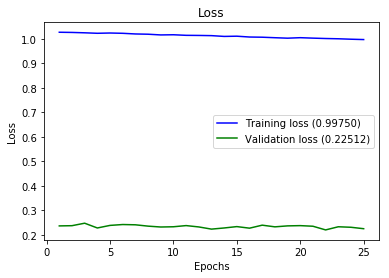

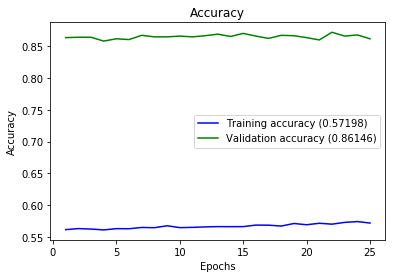

In [0]:
plot_history(classifier.history)

Laod Model

In [20]:
from keras.models import load_model
dic = "/content/drive/My Drive/Colab Notebooks/"
batch = 1024
epoch = 100
model = load_model(dic+f'SaveModel/CNN6-192(1,3)-128(2,3)-128(1,3)-64(1,3)-64(1,3)-64(1,3)-32(1,3)-ba{batch}-ep{epoch}-(dout=0.5)-input(IQ)(SNR=all).h5')

print('Model loaded!')

Model loaded!


In [21]:
classifier = model
classifier.get_config()






{'layers': [{'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'batch_input_shape': (None, 2, 128, 1),
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 192,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (1, 3),
    'name': 'conv2d_32',
    'padding': 'same',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True}},
  {'class_name': 'Dropout',
   'config': {'dtype': 'float32',
    'name': 'dropout_38',
    'noise_shape': None,
    'rate': 0.5,
    'seed': None,
    'trainable': True}},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    